In [1]:
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import cv2
from pathlib import Path
import keras
import tensorflow_datasets as tfds
from keras import layers
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization , Input , Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from google.colab import drive
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.layers import Rescaling # New import
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
from tensorflow.keras.layers import LeakyReLU






def iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_score)
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

folder = '/kaggle/input/mribrain/siav'
def natural_sort(item):
    numbers = re.findall(r'\d+', item)
    # If numbers are found, convert to integer, otherwise return 0
    return int(numbers[-1]) if numbers else 0


mask_list = []
image_list = []
for paths, dirs, files in os.walk(folder):
    for file in files:
        if 'mask' in file:
             mask_list.append(os.path.join(paths, file))

             mask_list.sort(key = natural_sort )

        else :
              image_list.append(os.path.join(paths, file))

              image_list.sort(key= natural_sort)

print(len(image_list))
print(len(mask_list))


image_list = [tf.keras.preprocessing.image.load_img(i) for i in image_list]
image_list = [tf.image.resize(i, (256, 256)) for i in image_list]


mask_list = [tf.keras.preprocessing.image.load_img(i) for i in mask_list]
mask_list = [tf.image.resize(i, (256, 256)) for i in mask_list]
mask_list = [tf.image.rgb_to_grayscale (i) for i in mask_list]


image_array = np.array([np.array(img) for img in image_list])
mask_array = np.array([np.array(mask)/255.0 for mask in mask_list])
mask_array = (mask_array > 0.5).astype(np.float32)
print(len(image_list))
print(len(mask_list))
print(np.unique(mask_array))  # Check the values in your masks


ddata = tf.data.Dataset.from_tensor_slices((image_array,mask_array))



ddata = ddata.shuffle(buffer_size=300, seed=None)

train_size = int(0.8 * len(ddata))
val_size = len(ddata) - train_size
train_ds = ddata.take(train_size)
val_ds = ddata.skip(train_size).take(val_size)

train_ds = train_ds.batch(10)
val_ds = val_ds.batch(10)


from tensorflow.keras.optimizers import Adam
opti = Adam(learning_rate=1e-4)
dice_loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size', name='dice'
)
def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.5 * dice + 0.5 * bce

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


680
680
680
680
[0. 1.]


In [3]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/input/mri_brain/tensorflow2/default/1/modele.keras', custom_objects={'mish': mish , 'iou' : iou , 'combined_loss' : combined_loss} )
for layer in model.layers:
    layer.trainable = True

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 77s 788ms/step - iou: 0.3865 - loss: 0.2551 - val_iou: 0.5917 - val_loss: 0.0999
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - iou: 0.6025 - loss: 0.1149 - val_iou: 0.6490 - val_loss: 0.0843
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - iou: 0.6679 - loss: 0.0851 - val_iou: 0.6499 - val_loss: 0.0842
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - iou: 0.7029 - loss: 0.0709 - val_iou: 0.7554 - val_loss: 0.0655
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - iou: 0.7097 - loss: 0.0738 - val_iou: 0.7799 - val_loss: 0.0491
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - iou: 0.7487 - loss: 0.0614 - val_iou: 0.7752 - val_loss: 0.0521
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - iou: 0.7821 - loss: 0.0552 - val_iou: 0.7825 - val_loss: 0.0455
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - iou: 0.7674 - loss: 0.0538 - val_iou: 0.7957 - val_loss: 0.0477
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/

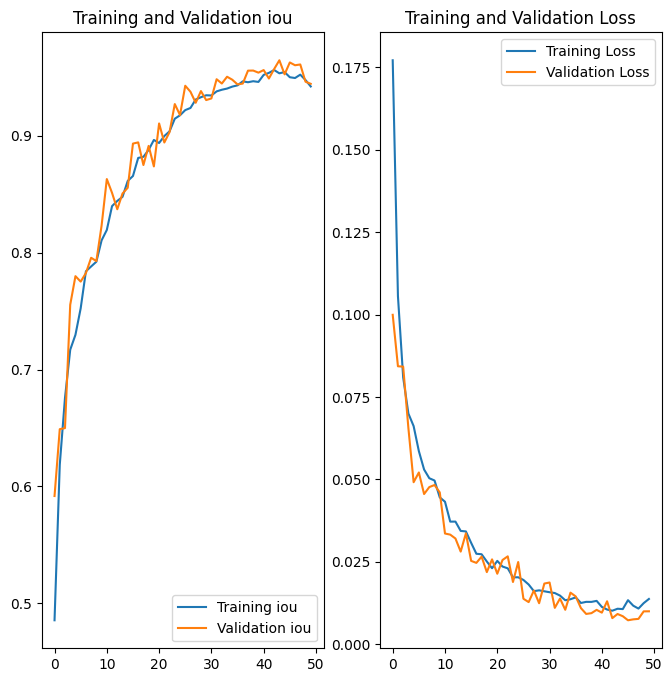

In [4]:
epochs=50
model.compile(optimizer=opti,
              loss= combined_loss  ,
              metrics=[iou])
history = model.fit(
  train_ds,
  validation_data=val_ds,
   epochs=epochs )
acc = history.history['iou']
val_acc = history.history['val_iou']

loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training iou')
plt.plot( val_acc, label='Validation iou')
plt.legend(loc='lower right')
plt.title('Training and Validation iou')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [7]:
model.save( 'modelx.keras')

In [8]:
folderb = '/kaggle/input/test-brain'
mask_listb = []
image_listb = []
for paths, dirs, files in os.walk(folderb):
    for file in files:
        if 'mask' in file:
             mask_listb.append(os.path.join(paths, file))

             mask_listb.sort(key = natural_sort )

        else :
              image_listb.append(os.path.join(paths, file))

              image_listb.sort(key= natural_sort)

print(len(image_listb))
print(len(mask_listb))


image_listb = [tf.keras.preprocessing.image.load_img(i) for i in image_listb]
image_listb = [tf.image.resize(i, (256, 256)) for i in image_listb]


mask_listb = [tf.keras.preprocessing.image.load_img(i) for i in mask_listb]
mask_listb = [tf.image.resize(i, (256, 256)) for i in mask_listb]
mask_listb = [tf.image.rgb_to_grayscale (i) for i in mask_listb]

image_arrayb = np.array([np.array(img) for img in image_listb])
mask_arrayb = np.array([np.array(mask)/255.0 for mask in mask_listb])
mask_array = (mask_array > 0.5).astype(np.float32)
print(len(image_listb))
print(len(mask_listb))
print(np.unique(mask_arrayb))

ddatab = tf.data.Dataset.from_tensor_slices((image_arrayb,mask_arrayb))



test_ds = ddatab.shuffle(buffer_size=100, seed=None)
test_ds = test_ds.batch(10)

120
120
120
120
[0.         0.99990004]


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - iou: 0.6855 - loss: 0.1322
Test Loss: 0.1447834074497223
Test IoU: 0.6749923229217529
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


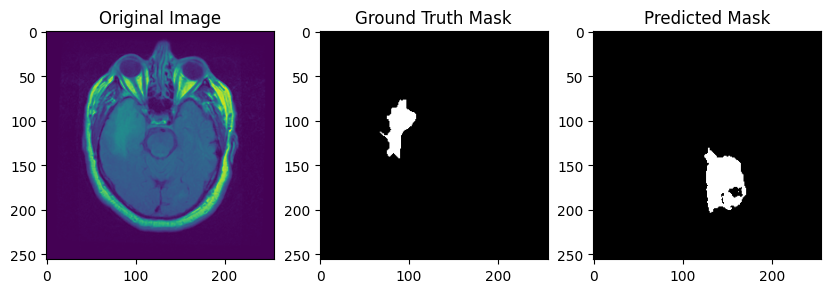

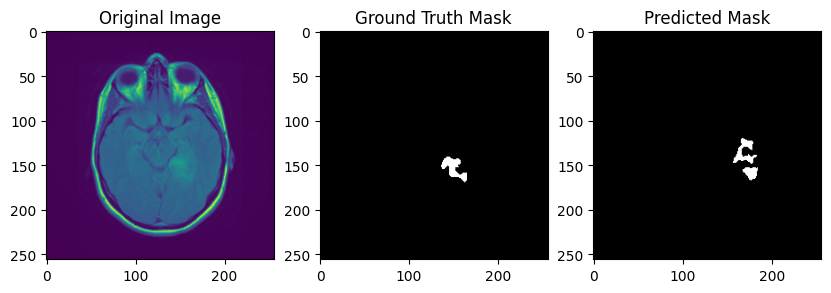

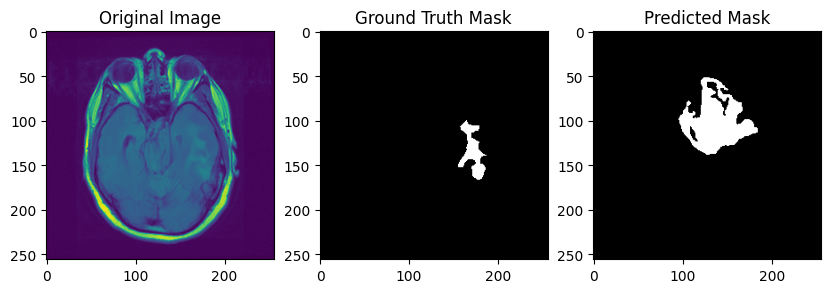

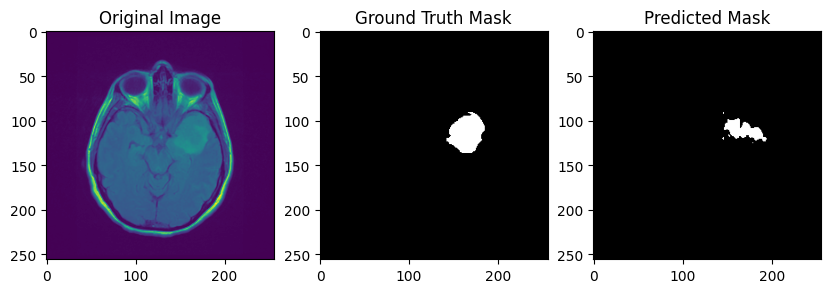

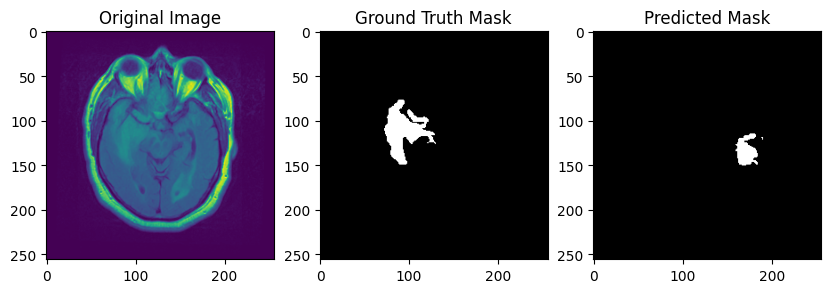

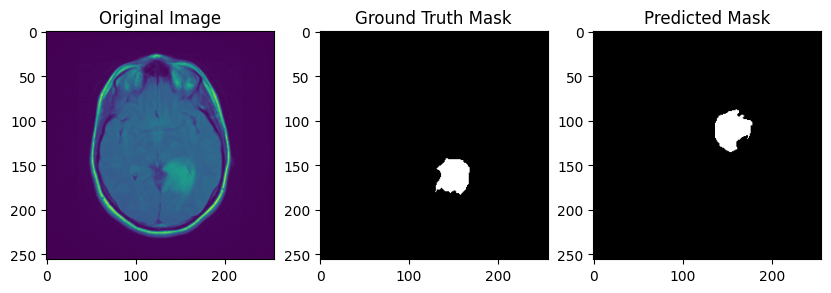

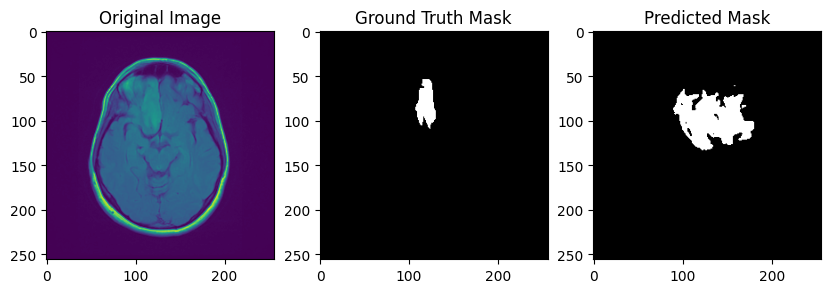

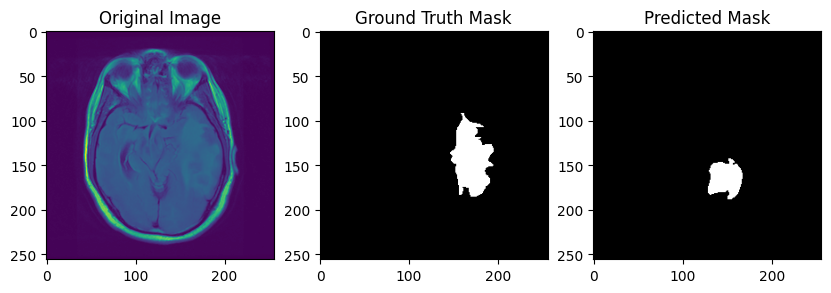

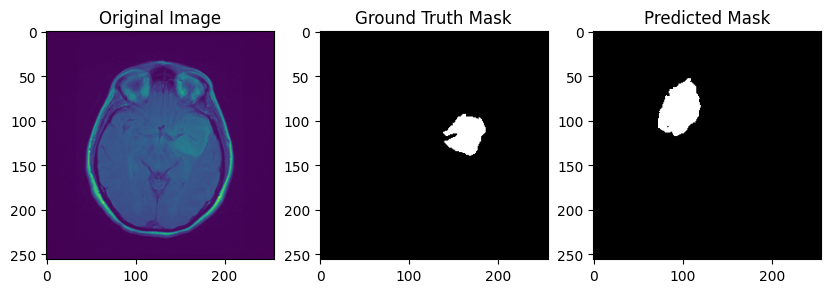

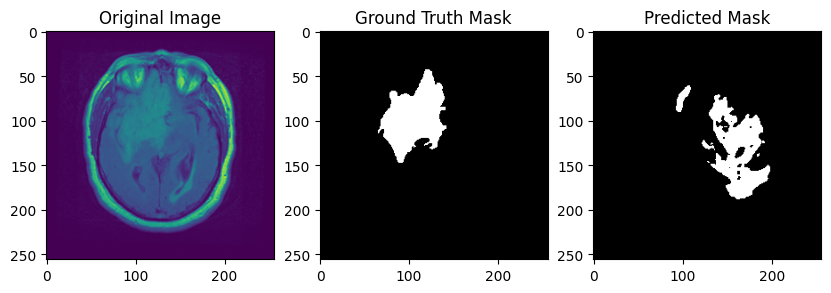

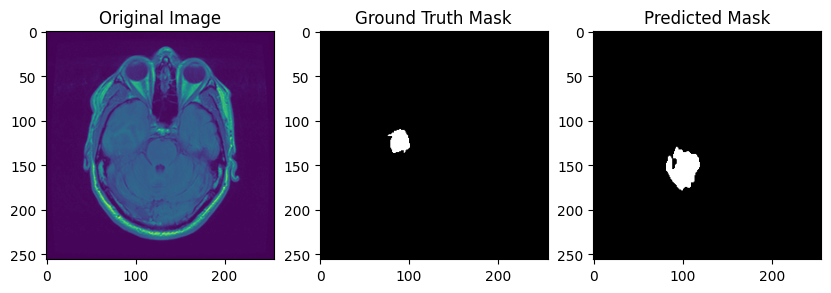

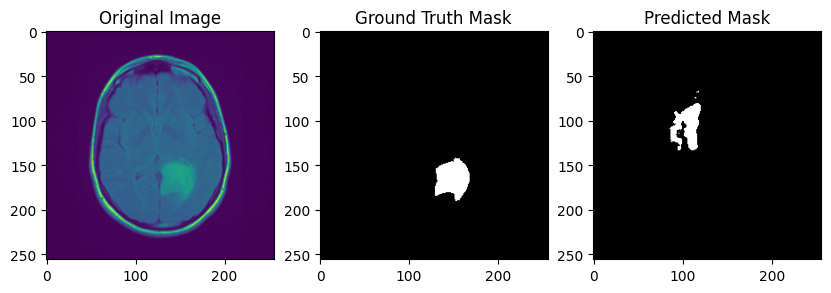

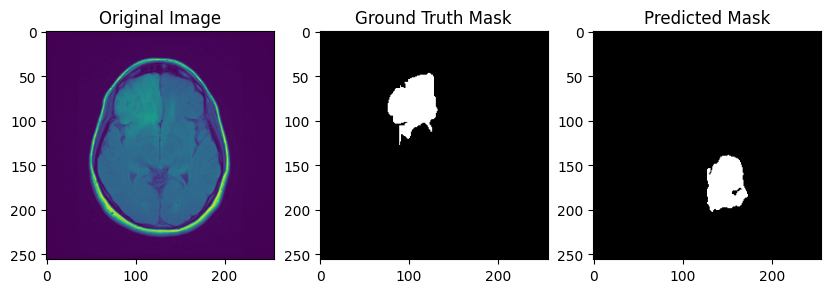

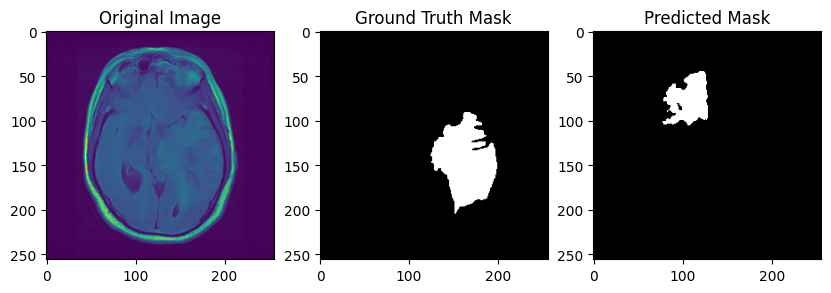

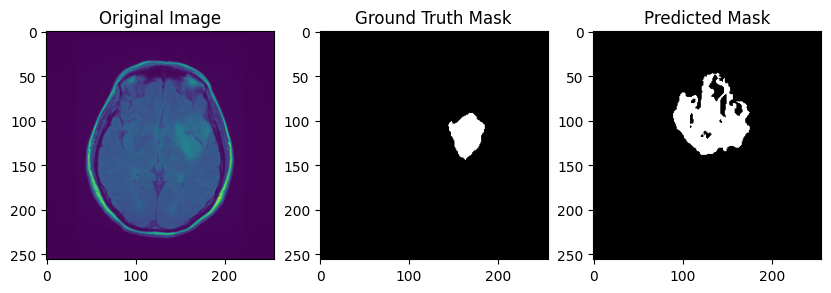

In [13]:
test_loss, test_iou = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test IoU: {test_iou}")



predictions = model.predict(test_ds)


binary_predictions = (predictions > 0.5).astype(np.float32)
image_listb = [tf.image.rgb_to_grayscale (i) for i in image_listb]

import matplotlib.pyplot as plt

for i in range(15):
    plt.figure(figsize=(10, 10))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_listb[i])
    plt.title("Original Image")

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_arrayb[i].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_predictions[i].squeeze(), cmap="gray")
    plt.title("Predicted Mask")

    plt.show()